# ANALYSIS
***

Now that we have cleaned data, we can run some analyses on it. We collected information on **81** different prominent (primarily english-speaking) channels. The reason we selected primarily english-speaking channels is so that we can perform NLP tasks on them. From each channel, we collected information on their last **50** uploads. From here, we can explore these data to see if we can gain insights into the performance, demographics, and more, about these channels.

**Channel Selection Criteria**
- greater than or equal to 1 million subscribers
- primarily english-speaking, or audience is primarily english-speaking


Note: we also tried to obtain a sample of channels coming from a wide range of different genres. It's worth noting that there are roughly 35,000 channels with over 1 million subs, according to [Awesome Creator Academy](https://www.awesomecreatoracademy.com/blog/how-many-youtube-channels-have-1-million-subscribers), so our sample size is rather small in the context of the entire platform. Hence, we tried to generalize our selections across a wide set of genres to better represent the channels that have a marked influence on the platform. To that end, the same source estimates that there exists roughly 150 million+ channels with less than 1 million subscribers, though their overall impact on the platform as a whole is much less significant.

<br>

### Terminology:
- "viral video" / "successful video"
    - a video whose view count exceeds the channel's subscriber count
- "subscriber base"
    - the number of accounts subscribed to a YouTube channel


<br>

## Research Questions
- *what words are most commonly used in video titles?*
- *which channels post most frequently?*
- *what proportion of the data consists of shorts, livestreams, or other?*
- *does a relationship exist between video length and number of views?*


#### NOTES:
This data was collected on 10/23/2023, hence the view counts of videos posted near this date are subject to change

In [63]:
import math
from importlib import reload
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# local files
import preprocessing
import analyzer


pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.0f}'.format

# update local files with any changes
reload(preprocessing)
reload(analyzer)

<module 'analyzer' from 'C:\\Users\\Matt\\DataspellProjects\\Youtube Data Analytics\\analyzer.py'>

In [28]:
videos = pd.read_csv(preprocessing.CLEAN_DATA.joinpath('videos_cleaned.csv'))
vid_df = pd.DataFrame(videos)

channel_info = pd.read_csv(preprocessing.DATA.joinpath('channels.csv'))
channel_df = pd.DataFrame(channel_info)
vid_df.sample(10)

,video_id,channel_name,description,video_title,upload_date,length,num_views,length_secs
2317,AHc8fgxO2ac,OneyPlays,Subscribe for more Oney Plays ► http://bit.ly/...,BEST OF Channel Awesome References (Funniest M...,2023-10-15,0:40:10,199872,2410
22,nRebRhmeMk0,Bon Appétit,"Japanese chef Yuji Haraguchi, owner of OKONOMI...",How a Japanese Chef Turns a Whole Fish Into 6 ...,2023-09-12,0:21:10,557952,1270
2310,Ub76K-5x3zk,OneyPlays,Subscribe for more Oney Plays ► http://bit.ly/...,THE MORTUARY ASSISTANT,2023-10-19,0:22:45,208576,1365
746,wU21oR8tGVk,Hongyu ASMR 홍유,"🌋 ASMR 직접 만든 매운 소꼬리찜, 매콤 스지(소힘줄), 쫀득쫀득 돼지껍데기 ,...",ASMR MUKBANG| SPICY FOODS 매운 음식 먹방 소꼬리찜 돼지껍데기 ...,2023-07-14,0:10:51,754642,651
2933,UY0rX4k7Xv4,NBA,"Never miss a moment with the latest news, tren...",WIZARDS at RAPTORS | NBA PRESEASON FULL GAME H...,2023-10-21,0:09:35,175066,575
3919,SOa7ItjO9VQ,Jarvis Johnson,4:35 - demi lovato uses they/them pronouns! th...,MTV's Show About 'Yo Momma' Jokes Was Low-Key ...,2021-07-01,0:33:31,3185333,2011
3483,ey3hbsynrPI,videogamedunkey,Donkey Kong on ice.\n\ndonkey store https://du...,Donkey Kong Tropical Freeze,2022-12-28,0:05:27,2346837,327
1499,HqIct7O0460,Unbox Therapy,Anker 727 Charging Station: https://ankerfast....,The Holy Grail of Charging ⚡ #apple #applemacb...,2023-07-11,0:01:00,842949,60
1569,EhiZ6xYJxnQ,JerryRigEverything,One of the First Tesla's ever made can be your...,I FOUND THE ORIGINAL TESLA - (Same car Elon La...,2023-09-14,0:11:20,592464,680
308,nLgt4Z5L8XI,TED-Ed,"Follow Maxo, a warrior of the Chimu Empire, as...",A day in the rebellion against the Inca Empire...,2023-09-28,0:04:57,171869,297


In [29]:
def search_channel(channel_name: str):
    """returns all entries in vid_df posted by the channel specified"""
    return vid_df.loc[vid_df['channel_name'] == channel_name] if channel_name in channel_df['channelName'].tolist() else vid_df.loc[vid_df['channel_name'].str.contains(channel_name)]

## I. Upload Schedules
---

Suppose we wish to answer the question: *Which YouTube channel post most frequently?*
To do this, we must find a way to compare the upload schedules among various channels. Given that we have the dates of each channel's previous 50 uploads, we can perform a few calculations that will lead us to an answer.

Before answering this graphically, let's understand the intuition behind these calculations numerically.

Note that the timespan for each channel's last 50 uploads will differ wildly, depending on how many videos the channel publishes a day. In the case of News channels, we'd expect this to relatively high, whereas with Animation channels, this may be much lower due to the length of time a single video takes to produce. Hence, it may be more useful to calculate a timespan relative to each channel, rather than picking a time interval to compare each channel against and counting the number of videos each one posted within that timespan.

Therefore, for each channel we will calculate an *upload_timespan* and *upload_rate*. The former represents the duration between their most recent upload, and their 50th most recent upload. Since *upload_timespan* is a relative measure, *upload_rate* will be relative as well. *upload_rate* can be interpreted as the average number of videos the channel uploads per day (based on their upload schedule from their last 50 videos), which will be inversely proportional to their respective *upload_timespan*.

These measurements will allow us to numerically determine which channels post most frequently. Channels with the highest *upload_timespan* represent the channels that post videos most infrequently, or at the very least, have large gaps between uploads. Hence, if a channel's last 50 uploads were all posted in 1 day, we'd expect their *upload_rate* to be 50. Of course, its worth mentioning that this calculation does not take into account the lengths of the videos themselves, so this should not be interpreted as a channel's "productivity", or anything related to the content of the videos themselves.

In [30]:
import datetime
def calculate_upload_time_span(channel_name: str):
    """calculates the timespan between the channel's last 50 uploads"""
    dates = pd.DataFrame(search_channel(channel_name)['upload_date']).sort_values(by='upload_date', ascending=True).to_numpy()
    return datetime.datetime.strptime(dates.flatten()[-1],'%Y-%m-%d') - datetime.datetime.strptime(dates.flatten()[0], '%Y-%m-%d')


def calculate_upload_rate(channel_name: str):
    """calculates the relative upload_rate based on the channel's last 50 videos"""
    upload_rate = len(search_channel(channel_name)['upload_date'].to_list()) / (calculate_upload_time_span(channel_name).total_seconds() / (60 * 60 * 24))
    return round(upload_rate, 2)

In [31]:
new_df = pd.DataFrame(channel_df['channelName'])
new_df['upload_timespan'] = new_df['channelName'].apply(lambda x: calculate_upload_time_span(x))
new_df['uploads_per_day'] = new_df['channelName'].apply(lambda x: calculate_upload_rate(x))
new_df.sort_values(by='uploads_per_day', ascending=False)[:10]

,channelName,upload_timespan,uploads_per_day
60,ESPN,1 days,50
4,NBC News,1 days,50
12,CBS News,1 days,50
58,NBA,4 days,12
1,CNN,4 days,12
11,MLB,4 days,12
37,The Tonight Show Starring Jimmy Fallon,6 days,8
50,BBC News,7 days,7
48,The Majority Report w/ Sam Seder,7 days,7
44,Guardian News,8 days,6


From this table, we can see the 10 channels with the highest upload frequencies, which rather unsurprisingly, appears to entirely contain cable TV shows and News networks.
Next, let's see how this result compares to an absolute measurement of upload frequency.

Below we define the function `plot_upload_dates()`, which plots each channel provided to it as its own timeline of upload dates, where each dot on their respective timeline represents the day the channel uploaded.
For channels that post very frequently, their lines should be rather short, and dense with dots. This will also allow us to observe any large gaps between posts for certain channels.

In [32]:
def plot_upload_dates(channel_names: list | str):
    """graphs one or more channels' last 50 upload dates as a timeline"""
    if isinstance(channel_names, str):
        channel_names = [channel_names]

    for i, channel_name in enumerate(channel_names):
        df = search_channel(channel_name)
        date_strings = df['upload_date']
        dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in date_strings]
        y_values = [i + 1] * len(dates)
        plt.plot(dates, y_values, marker='o', linestyle='-', label=channel_name)

    plt.xlabel('Date')
    plt.title('Last 50 Upload Dates by Channel')
    plt.xticks(rotation=45)
    plt.legend()
    plt.yticks([])
    plt.show()

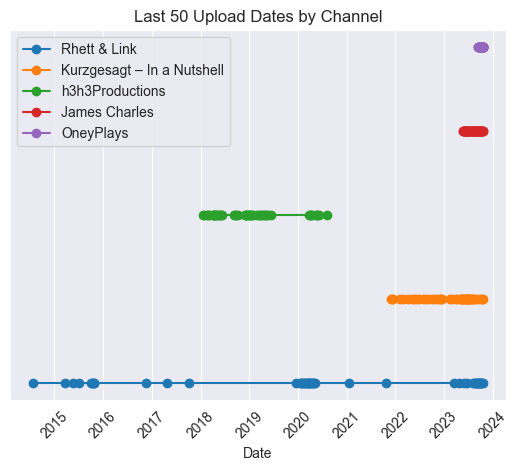

In [33]:
# random_channels = pd.DataFrame(channel_df['channelName'].sample(5))['channelName'].to_list()

# this list was initially generated at random using the line above, but was initialized here, so it doesn't change between runs of this file
random_channels = ['Rhett & Link', 'Kurzgesagt – In a Nutshell', 'h3h3Productions', 'James Charles', 'OneyPlays']
plot_upload_dates(random_channels)

This graph encodes a lot of information pertaining to the channels and their upload schedules.
- Among the sample chosen, we see that **OneyPlays** is the most frequent uploader, given that their timeline is the shortest and most densely packed with dots.
- We can also determine that the most inconsistent uploader of the sample is the channel **Rhett & Link**, whose timeline is the longest, which can be explained by long gaps between uploads in the past, though it appears they post  quite frequently as of late.
- Lastly, we can see that the channel **h3h3productions** appears to be defunct, since their timeline stops around mid-2020 (and checking the site, this is confirmed to be true).

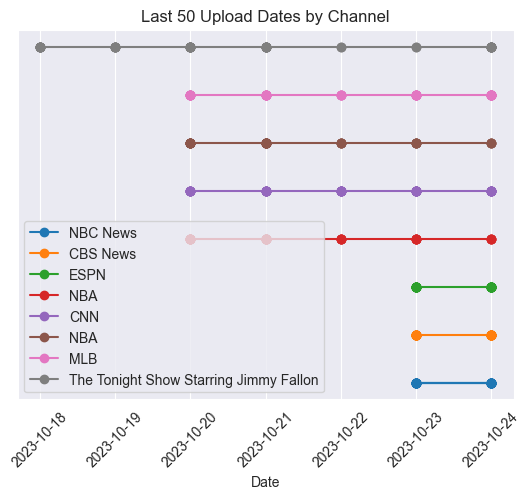

In [34]:
channels = ['NBC News', 'CBS News', 'ESPN', 'NBA', 'CNN', 'NBA', 'MLB', 'The Tonight Show Starring Jimmy Fallon']
plot_upload_dates(channels)

Note that by plugging in the channels we found had the highest *upload_rates*, we see that their upload schedules are quite uniform, and that they post multiple videos a day. According to our data, **NBC News** and **CBS News** are the most frequent posters. Also note that this visualization technique is less useful when comparing channels with high consistent output because it results in uniformly-spaced upload dates, which can be seen above. This technique is most insightful when comparing channels that differ greatly in their upload schedules because any gaps in uploads are more visible.

## II. Video Duration
___

Next, we can determine which channel (on average) posts the most content in terms of video duration. First, we must calculate the *average_video_length*, which can be obtained by taking the mean of their video durations.
We must be careful though, since this value is highly susceptible to the nature of the content itself, i.e. whether the uploads considered in this calculation are a "typical video", a Short, or a stream. What constitutes a "typical video" for a channel varies widely, isn't very straightforward, and requires a strong understanding of the channel's themselves. Many channels also engage their audience with alternative forms of content, such as livestreams, which are long-form in nature, or Shorts, which as the name implies, are quite short and typically are less than a minute in length. It's important to keep this in mind going forward, since these will heavily skew the values we obtain when calculating the average video duration.

Currently, the YouTube API lacks a way to specify what form of content the upload falls under, but for our purposes, we will assume any video shorter than 1 minute qualifies as a Short, and any over 1 hour will be considered a livestream (only if videos of that length are uncommon for the channel).

In [35]:
from datetime import timedelta

def calculate_avg_video_duration(channel_name: str):
    """calculates arithmetic mean of video lengths"""
    total_duration = timedelta()
    durations = pd.DataFrame(search_channel(channel_name))['length'].tolist()
    for time_str in durations:
        hours, minutes, seconds = map(int, time_str.split(":"))
    duration = timedelta(hours=hours, minutes=minutes, seconds=seconds)
    total_duration += duration
    return str(total_duration)

def classify_upload_type(time_str: str, channel_name: str):
    """assign the entry a category based on its video length and the average duration of videos from the channel"""
    channel_mean_upload_duration = calculate_avg_video_duration(channel_name)
    mean_duration = analyzer.duration_to_secs(channel_mean_upload_duration)
    duration_ = analyzer.duration_to_secs(time_str)

    if duration_ >= timedelta(hours=1) and mean_duration <= duration_:
        return 'medium'
    elif duration_ <= timedelta(minutes=1) and mean_duration > duration_:
        return 'short'
    elif duration_ >= timedelta(hours=1) and mean_duration >= timedelta(hours=1):
        return 'long'
    elif duration_ <= timedelta(minutes=1) and mean_duration <= timedelta(minutes=1):
        return 'short'
    else:
        return 'medium'

In [36]:
channels = channel_df['channelName'].tolist()
channel_df['avg_upload_duration'] = channel_df['channelName'].apply(lambda x: calculate_avg_video_duration(x))
channel_df[['channelName', 'viewCount', 'subscriberCount', 'videoCount', 'avg_upload_duration']].sample(5)

,channelName,viewCount,subscriberCount,videoCount,avg_upload_duration
61,Markiplier,20647945718,35600000,5520,0:51:13
59,Abroad in Japan,457315746,2900000,264,0:17:46
17,h3h3Productions,1363063323,5960000,275,0:11:34
1,CNN,14843457695,15700000,161812,0:10:40
31,JerryRigEverything,1855036598,8120000,1085,0:01:00


In [37]:
vid_df['content_type'] = list(map(lambda x, y: classify_upload_type(x, y), vid_df['length'], vid_df['channel_name']))
vid_df.sample(5)

,video_id,channel_name,description,video_title,upload_date,length,num_views,length_secs,content_type
1463,5vDbySza_qs,Unbox Therapy,Get a Free invisible selfie stick for the Inst...,Elevate Your Underwater Footage…,2023-09-21,0:01:00,245368,60,short
849,fMt2ca4jdY4,Babish Culinary Universe,Thanks to my friends at The Singleton for spon...,How to Make the Best Pasta Salad (Three Ways) ...,2023-05-25,0:09:48,569358,588,medium
3735,4yf-PZDQ_34,ArianaGrandeVevo,Music video by Ariana Grande performing 34+35 ...,Ariana Grande - 34+35 (Remix / Lyric Video) ft...,2021-01-15,0:03:01,28894656,181,medium
3805,zJdr-DLoKLA,Philip DeFranco,Use my link to install Dungeon Hunter VI for ...,"The SSSniperwolf Situation Got Worse, Youtube ...",2023-10-19,0:28:31,889620,1711,medium
857,TBql5f5ipDI,h3h3Productions,TEDDY FRESH...http://teddyfresh.com\r\nH3 MERC...,Awful Products That Shouldn't Exist,2020-03-30,0:17:28,2933102,1048,medium


In [38]:
# assign category to video based on video length and avg video length
shorts, meds, longs = [i for i in vid_df['length_secs'] if i <= 60], [i for i in vid_df['length_secs'] if 60 < i < 3600], [i for i in vid_df['length_secs'] if i >= 3600]
len(shorts), len(meds), len(longs)

(1021, 2864, 165)

In [39]:
content_types = Counter(vid_df['content_type'].tolist())
labels, counts = zip(*content_types.items())
category_order = ['Short', 'Medium', 'Long']

df = pd.DataFrame(content_types.items(), columns=['type', 'count'])
df = df.reindex([1, 0, 2])

df['%'] = df['count'].apply(lambda x: round((x / df['count'].sum()) * 100), 2)
df

,type,count,%
1,short,1021,25
0,medium,2998,74
2,long,31,1


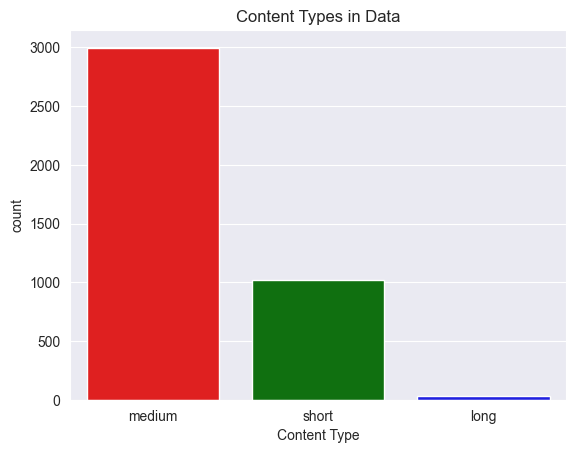

In [40]:
sns.countplot(data=vid_df, x='content_type', palette=['red', 'green', 'blue'])
plt.title('Content Types in Data')
plt.xlabel('Content Type')
plt.show()

We can see that the majority of our data is categorized as **medium** length, meaning most of our videos have a run time between 1 minute and an hour.

## III. Video Titles
***
Video titles can greatly impact a video's success in the current age of YouTube, in conjunction with thumbnails. The mechanisms behind YouTube's video recommendation system tends to favor those with flashy titles, and as a result creator's will often modify their video titles shortly after posting them to improve their performance. This can result in patterns in video titles, as creator's optimize their content for the sake of reaching a wider audience.
Please note that in the case of some creators that most several or more videos daily, such as News shows, their titles may be more reflective of current trends than others. Hence, we are essentially taking a look at what video

In this section we will investigate video titles for a sample of creators, and relative to the entire population of our dataset through various NLP techniques. First let's see what words appear most frequently in the population.

In [48]:
title_df = vid_df[['video_title', 'channel_name']]
title_df.sample(10)

,video_title,channel_name
1323,if you don’t live in NYC or youre watching thi...,CaseyNeistat
1622,Bored,Domics
2756,Sleeping Beauty Paradox - Numberphile,Numberphile
2097,The Unexpected Measure that Makes the Modern W...,Be Smart
460,Game Theory: Bow Before Him! (Poppy Playtime C...,The Game Theorists
3898,"""We must continue to move our feet."" Former US...",The Daily Show
425,POV: Velma Has A Panic Attack,MeatCanyon
3400,Why Henry VIII's Codpiece Is So...Monumental,Nerdwriter1
1687,Why You Are Lonely and How to Make Friends,Kurzgesagt – In a Nutshell
2200,Family members British-Israeli Hamas hostages ...,Guardian News


In [49]:
title_df['keywords'] = title_df['video_title'].apply(lambda x: analyzer.bag_of_words(x, True))
all_titles = title_df['keywords'].tolist()

In [52]:
word_counts_population = analyzer.count_words(all_titles)
word_counts_population.most_common(10)

[('shorts', 204),
 ('Show', 102),
 ('Game', 93),
 ('vs', 91),
 ('2', 87),
 ('News', 86),
 ('Gaza', 83),
 ('Live', 82),
 ('Tonight', 79),
 ('ASMR', 78)]

Interestingly enough, 'shorts' is the most common word used in titles among our dataset, after removing stop words. Upon inspection, we find that this is because many creators have appended '#shorts' to the end of their title if they are posting a short. So we do have (at least to some degree) a way to tell which videos are shorts, with a fair degree of confidence. Although, it's not likely that all creators choose to do this with their titles.
Apart from 'shorts', we see that words like 'Show', 'Game', 'Live', and 'ASMR' and 'News' are also very commonly used terms in titles in our data. It's quite common for YouTuber's to append their channel name to the end of their video title, which could explain why we see words like these appear most frequently. Overall, it doesn't appear that we can extract much more information from this data due to this fact.

In [53]:
word_counts_population.most_common(len(word_counts_population))[10:30]

[('Video', 66),
 ('John', 62),
 ('Week', 61),
 ('2023', 61),
 ('Last', 58),
 ('5', 57),
 ('Hamas', 57),
 ('Can', 54),
 ('Course', 53),
 ('Shorts', 52),
 ('Made', 51),
 ('THE', 51),
 ('New', 51),
 ('Oliver', 51),
 ('Crash', 51),
 ('Numberphile', 50),
 ('House', 49),
 ('Israel', 49),
 ('Ariana', 49),
 ('Grande', 49)]

## IV. Descriptive Statistics of Video View Counts
***

Let's get an idea of the shape of various numeric features within the data using various statistical methodologies. Note, we will calculate the sample versions of these metrics, since our data represents a small portion of the population of YouTube channels, which we are trying to identify trends for.

#### Sample Variance

$S^2 = \frac{1}{n - 1}\sum_{i=1}^{n}(x_i - \overline{x})^2$
<br>

#### Sample Std. Dev.
$s = \sqrt{S^2} = \sqrt{\frac{1}{n - 1}\sum_{i=1}^{n}(x_i - \overline{x})^2}$

<br>

$x_i = \text{value of observation i}$ <br>
$\overline{x} = \text{mean value of all observations}$ <br>
$n = \text{number of observations}$

In [65]:
# perform these calculations using our own functions instead of pandas (just for fun), we obtain the same results either way
samples = vid_df['num_views'].to_list()

x_bar = analyzer.sample_mean(samples)
variance = analyzer.sample_variance(samples)
std_dev = analyzer.sample_std_dev(variance)

q1, median, q3, iqr = analyzer.quartile_info(samples)
print(f"MEAN: {x_bar}\nQ1: {q1}\nQ3: {q3}\nIQR: {iqr}\nMEDIAN: {median}\nVARIANCE: {variance}\nSTD DEV: {std_dev}")

MEAN: 6395433.85
Q1: 121732
Q3: 3421794
IQR: 3300062
MEDIAN: 774090.0
VARIANCE: 1040913826205361.4
STD DEV: 32263196.16


As we can see, the value of the variance of our view count data is absolutely massive. This may be a result of videos that were posted very recently relative to when this data was curated, and have little to no views yet. And based on our previous observations, news channels are the most frequent posters, so the number of videos with very low view count may be higher if most of their respective channels are news channels. Similarly, a small subset of videos with very high view counts may have an impact the values of some of these metrics.

In terms of the IQR, the middle 50% of our data encompasses videos with as little as 120k views all the way to 3.4mil views. This is the portion of our sample we are most interested in, since it is less susceptible to the outliers we observe (as mentioned above)

We should also note that the view count data we've captured represents these channels at a snapshot in time, hence these numbers are due to change, and may not accurately reflect the population as the platform changes with time.

#### V. Subscriber / View Count Comparisons
***
Now that we have some information about various descriptive features of the data, we can dive further into the massive variance we have.

First lets take a look at the subscriber counts for the channels with a nice histogram.


In [55]:
subscriber_df = channel_df[['channelName', 'subscriberCount']]
subscriber_df.sample(5)

,channelName,subscriberCount
64,Dream,31900000
26,CaseyNeistat,12600000
55,Numberphile,4370000
9,The Game Theorists,18000000
44,Guardian News,3350000


In [56]:
import math

min_subs, max_subs = subscriber_df['subscriberCount'].min(), subscriber_df['subscriberCount'].max()
num_bins = math.ceil(math.sqrt(len(subscriber_df.subscriberCount.to_list())))
bin_width = math.ceil((max_subs - min_subs) / len(subscriber_df.subscriberCount.to_list()))
bin_width, num_bins

(2503951, 9)

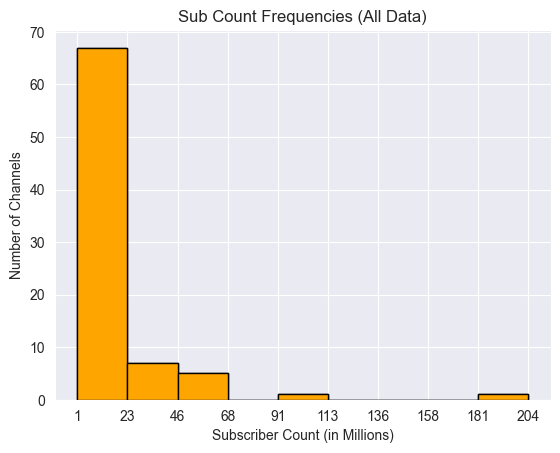

In [80]:
(n, bins, patches) = plt.hist(subscriber_df['subscriberCount'], bins=num_bins, edgecolor='black')
bin_labels = [f'{int(i / 1e6)}' for i in bins]
num_bins = len(bins) - 1
plt.hist(subscriber_df['subscriberCount'], bins=bins, edgecolor='black', color='orange')
plt.xlabel('Subscriber Count (in Millions)')
plt.ylabel('Number of Channels')
plt.title('Sub Count Frequencies (All Data)')
plt.xticks(bins, bin_labels)
plt.show()

Perhaps, a histogram is not very well suited to display our distribution, due to the presence of outliers in our data. We note that a large majority of the channels have between 1 and 23 million subscribers, where a select few larger sub counts. At any rate, this is likely why we have such a high variance.

From here, let's take a look at the distribution of channels within the first bin, since they make up roughly 82% of the channels in our data:

In [74]:
channels_under_23_mil_subs = subscriber_df[subscriber_df['subscriberCount'] <= bins[1]]
channels_under_23_mil_subs = channels_under_23_mil_subs.sort_values(by='subscriberCount', ascending=True)
channels_under_23_mil_subs[:10]

,channelName,subscriberCount
46,OneyPlays,1180000
53,HasanAbi,1310000
48,The Majority Report w/ Sam Seder,1370000
71,Drawfee Show,1850000
78,Jarvis Johnson,2040000
70,theneedledrop,2790000
59,Abroad in Japan,2900000
2,PBS Space Time,2960000
68,Nerdwriter1,3150000
21,PragerU,3170000


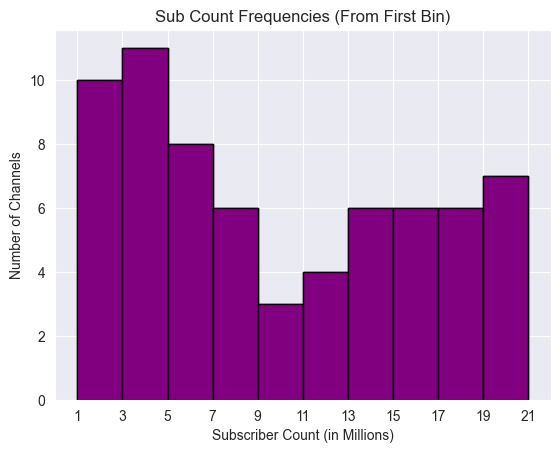

In [84]:
(n, bins, patches) = plt.hist(channels_under_23_mil_subs['subscriberCount'], edgecolor='black')
bin_labels = [f'{int(i / 1e6)}' for i in bins]
plt.hist(channels_under_23_mil_subs['subscriberCount'], edgecolor='black', color='purple')
plt.xlabel('Subscriber Count (in Millions)')
plt.ylabel('Number of Channels')
plt.title('Sub Count Frequencies (From First Bin)')
plt.xticks(bins, bin_labels)
plt.show()

We can see that we have a nice spread of subscriber counts for this subset of the data, though it appears to be roughly bimodal.
On the platform, reaching a sub count > 1mil is quite an achievement, and is a highly sought after milestone for many creators. Some channels tend to plateau in sub count after reaching this milestone, which we observe more or less from this figure. In a sense, we could interpret this idea as a "channel reaching its core audience".

The process of reaching the next milestone of >10mil subscribers is typically reserved for channels with the intent of long-term growth, or rapid short-term growth. Some channels are quite content with reaching the aforementioned 1 million subscriber milestone, and do not seek a much more significant level of success actively. Hence, channels that meet these criteria typically only reach the next major sub count milestone by either being popular on the platform for a long period of time (and their audience grows naturally as the number of users increases over time), or shift the topic of their content to more generalized ones to reach a wider audience. This has some interesting implications on both their video view counts, and viewer retention.

For instance, if a channel reaches 1 million subscribers making gaming-related content, it's safe to assume that their audience is made up of gamers or those who enjoy games. They may be able to reach 10 million or more subscribers if they branch out their content to other genres, or their audience disproportionately views their content for the creator's personality themselves, rather than the topic of the content.

#### Highly Successful Channels

Now that we understand a bit more about the majority of channels, let's try to get some insights into the highly successful channels in our sample, such as the kinds of content they make, and their video view counts. We proposed earlier that the more successful a channel is, the more likely their content is more general in nature, since they have to appeal to a wider audience with more diverse interests, rather than sticking to a single genre of content. Let's look into this to see if this is the case. We will choose an arbitrary lower bound for "highly successful" channels to be those beyond the first bin (>23 million subscribers).


In [88]:
highly_successful_channels = subscriber_df[subscriber_df['subscriberCount'] > 23000000]

In [93]:
channels = highly_successful_channels['channelName'].to_list()
dfs = [search_channel(name) for name in channels]
agg_df = pd.concat(dfs, ignore_index=True)

In [94]:
content_types = Counter(agg_df['content_type'].tolist())
labels, counts = zip(*content_types.items())
category_order = ['Short', 'Medium', 'Long']

odf = pd.DataFrame(content_types.items(), columns=['type', 'count'])
odf = odf.reindex([1, 0, 2])

odf['%'] = odf['count'].apply(lambda x: round((x / odf['count'].sum()) * 100), 2)
odf

,type,count,%
1,medium,426,68
0,short,183,29
2,long,13,2


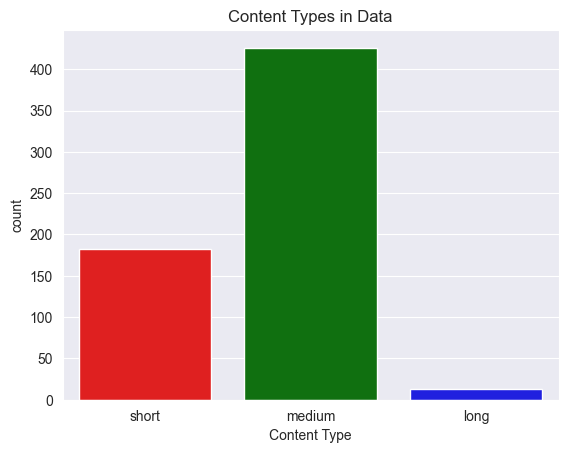

In [95]:
sns.countplot(data=agg_df, x='content_type', palette=['red', 'green', 'blue'])
plt.title('Content Types in Data')
plt.xlabel('Content Type')
plt.show()

Interestingly enough, we find that these channels upload more short content than the sample as a whole. Though their primary content type is still medium in length, it seems that posting more Shorts may play a role in growing a larger audience after becoming successful (reaching 1 million subs). The reason behind this is tough to pinpoint from the data we have, but perhaps either more viewers engage with Shorts now, or YouTube's content recommendation systems prefer short form content to others.